In [2]:
import json
import requests
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool
import time
import datetime as dt
import pandas as pd

In [3]:
def apiPost(endpoint, body=None):
    text = requests.post('{server}/api/v3/{endpoint}'.format(server=dremioServer, endpoint=endpoint), headers=headers, data=json.dumps(body)).text

    # a post may return no data
    if (text):
        return json.loads(text)
    else:
        return None
    
def apiGet(endpoint):
    return json.loads(requests.get('{server}/api/v3/{endpoint}'.format(server=dremioServer, endpoint=endpoint), headers=headers).text)

In [9]:
!ping 34.194.96.9

PING 34.194.96.9 (34.194.96.9) 56(84) bytes of data.
^C

--- 34.194.96.9 ping statistics ---
9 packets transmitted, 0 received, 100% packet loss, time 8191ms



In [13]:
username = 'admin'
password = 'covidlake@2020'
dremioServer = 'http://34.194.96.9'


def login(url, username, password):
    # we login using the old api for now
    headers={'content-type':'application/json'}
    loginData = {'userName': username, 'password': password}
    response = requests.post(str(url)+'/apiv2/login', headers=headers, data=json.dumps(loginData))
    data = json.loads(response.text)

    # retrieve the login token
    token = data['token']
    return {'content-type':'application/json', 'authorization':'_dremio{authToken}'.format(authToken=token)}

headers = login(dremioServer,username, password)

ConnectionError: HTTPConnectionPool(host='34.194.96.9', port=80): Max retries exceeded with url: /apiv2/login (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f52bb972198>: Failed to establish a new connection: [Errno 110] Connection timed out'))

In [49]:
def checkAPI(jobid):
    responseMessage = False
    
    while(not responseMessage):
        jobstatus = apiGet('job/{id}'.format(id=jobid))
        try:
            if(jobstatus['jobState'] == 'COMPLETED' or jobstatus['jobState'] == 'FAILED'):
                responseMessage = True
        except:
            pass

    return jobstatus

In [50]:
def querySQL(query):
    queryResponse = apiPost('sql', body={'sql': query})
    jobid = queryResponse['id']
    return jobid

In [51]:
def executeTest(query):
    jobid = querySQL(query)
    return checkAPI(jobid)

In [52]:
executeTest("SELECT * FROM nace_a")

{'jobState': 'FAILED',
 'errorMessage': "Table 'nace_a' not found",
 'startedAt': '2020-01-08T22:10:32.459Z',
 'endedAt': '2020-01-08T22:10:32.462Z',
 'queryType': 'REST',
 'queueName': '',
 'queueId': '',
 'cancellationReason': ''}

In [53]:
import statistics
def createStatistics(resultTest):

    executionTimes = []
    successNumber = 0 

    for result in resultTest:
        started = dt.datetime.strptime(result['startedAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
        ended = dt.datetime.strptime(result['endedAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
        executionTimes.append((ended - started).seconds)
        if(result['jobState'] == 'COMPLETED'):
            successNumber+=1

    successRatio = (successNumber/len(resultTestA))*100
    return [successRatio, executionTimes, max(executionTimes), min(executionTimes), statistics.mean(executionTimes)]

In [54]:
def futureTransform(resultTest):
    transformedResultTest = []
    for rt in resultTest:
        transformedResultTest.append(rt.result())
    return transformedResultTest

In [59]:
# PRD
query = ["select " + ', '.join(map(str, list(range(1, 301)))) +" from $scratch.stress_test_temp",
        "SELECT blobs FROM (SELECT FLATTEN(convert_from(blobs, 'JSON')) AS blobs FROM \"@administrator\".teste3mb)"]

# DEV
# query = ["select " + ', '.join(map(str, list(range(1, 301)))) +" from $scratch.teste_10kcolunas",
#          "SELECT blobs FROM (SELECT FLATTEN(convert_from(blobs, 'JSON')) AS blobs FROM \"@api\".teste3mb)"] 

In [60]:


testTime = 30
numParallelRequests = 64
results = []
while(numParallelRequests < 65): 
    resultTestA = []
    resultTestB = []
    print("Running: "+str(numParallelRequests))
    for i in range(1,testTime):
        with ThreadPoolExecutor(max_workers=numParallelRequests) as executor:
            for work in range(1,numParallelRequests+1):
                resultTestA.append(executor.submit(executeTest, query[0]))
                resultTestB.append(executor.submit(executeTest, query[1]))
        time.sleep(60)

    tResultTestA = futureTransform(resultTestA)
    tResultTestB = futureTransform(resultTestB)
    
    results.append([numParallelRequests, createStatistics(tResultTestA), createStatistics(tResultTestB)])
    
    partial = pd.DataFrame([numParallelRequests, createStatistics(tResultTestA), createStatistics(tResultTestB)])
    partial.to_csv("cenario_"+str(numParallelRequests)+".csv")
    
    numParallelRequests*=2
    time.sleep(120)

Running: 64


ConnectionError: HTTPConnectionPool(host='dremio4.vlrcloud.com', port=80): Max retries exceeded with url: /api/v3/job/21e9a8d3-1d71-23f7-5665-a91fa2e95100 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x11b67eef0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

In [29]:
#successRatio, executionTimes, max(executionTimes), min(executionTimes), statistics.mean(executionTimes)
def organizeResults(results):
    columns=['tipo','num_requests_paralelos', 'perc_jobs_completos', 'tempos_exec_array', 'max_tempo_exec', 'min_tempo_exec', 'media_tempo_exec']
    dfPayload = []
    for result in results:
        dfPayload.append(['coluna',result[0], result[1][0], result[1][1],result[1][2],result[1][3],result[1][4]])
        dfPayload.append(['blob',result[0], result[2][0], result[2][1],result[2][2],result[2][3],result[2][4]])
    df = pd.DataFrame(dfPayload, columns=columns)
    return df

In [30]:
df = organizeResults(results)

## df = pd.DataFrame([['coluna',30,1.0,[0,0,0,1],1,0,0.25],['coluna',10,1.0,[20,30,14,16],1,0,0.25]], columns=['tipo','num_requests_paralelos', 'perc_jobs_completos', 'tempos_exec_array', 'max_tempo_exec', 'min_tempo_exec', 'media_tempo_exec'])

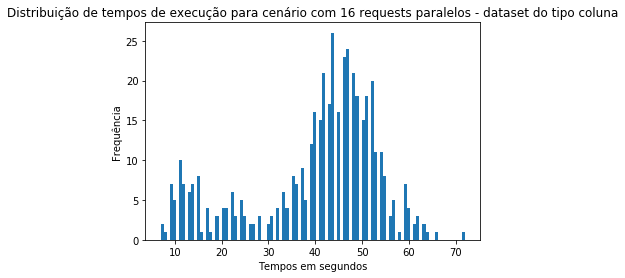

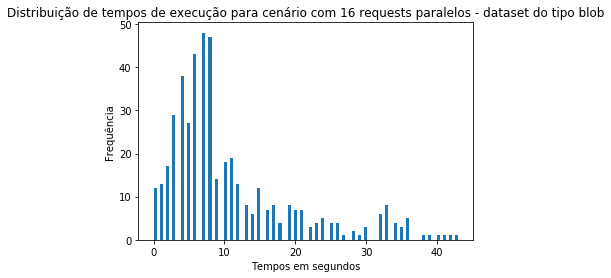

In [33]:
for index, row in df.iterrows():
#     pp.plot(row['tempos_exec_array'])
    plt.hist(row['tempos_exec_array'], bins= 100)
    plt.gca().set(title='Distribuição de tempos de execução para cenário com {num_requests_paralelos} requests paralelos - dataset do tipo {tipo}'.format(num_requests_paralelos=row['num_requests_paralelos'], tipo=row['tipo']), ylabel='Frequência', xlabel='Tempos em segundos');
    plt.show()

In [32]:
import matplotlib.pyplot as plt

In [61]:
d = df

In [64]:
d.to_csv('results_prod_16_32.csv')

In [34]:
df

,tipo,num_requests_paralelos,perc_jobs_completos,tempos_exec_array,max_tempo_exec,min_tempo_exec,media_tempo_exec
0,coluna,16,100.0,"[53, 57, 72, 60, 58, 63, 59, 52, 53, 49, 49, 5...",72,7,40.096983
1,blob,16,100.0,"[6, 11, 8, 8, 11, 13, 9, 11, 35, 15, 25, 33, 8...",43,0,10.760776
